In [1]:
# based on examples from https://github.com/pytorch/examples
# https://github.com/L1aoXingyu/pytorch-beginner/https://github.com/L1aoXingyu/pytorch-beginner/
# https://github.com/bfarzin/pytorch_aae/blob/master/main_aae.py
# https://github.com/artemsavkin/aae/blob/master/aae.ipynb
import argparse
import os
import torch
import time
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.nn import functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np
import torch.distributions as D


In [2]:
def save_reconstructs(model, x, epoch):
        with torch.no_grad():
            x = x.to(device)
            sample, _, __ = model(x)
            save_image(x.view(x.shape[0], 1, 28, 28),
                       'results/originals_' + str(epoch) + '.png')
            save_image(sample.view(x.shape[0], 1, 28, 28),
                       'results/reconstructs_' + str(epoch) + '.png')

def save_random_reconstructs(model, nz, epoch):
        with torch.no_grad():
            sample = torch.randn(64, nz).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, 28, 28),
                       'results/sample_' + str(epoch) + '.png')

class VAE(nn.Module):
    def __init__(self, nin, nz, nh1, nh2, nh3, nh4):
        super(VAE, self).__init__()

        self.nin = nin
        self.nz = nz

        self.encoder = nn.Sequential(
                nn.Linear(nin, nh1), 
                nn.ReLU(),
                nn.Linear(nh1, nh2),
                nn.ReLU(),
                )

        self.decoder = nn.Sequential(
                nn.Linear(nz, nh3),
                nn.ReLU(),
                nn.Linear(nh2, nh4),
                nn.ReLU(),
                nn.Linear(nh4, nin),
                nn.Sigmoid()
                )

        self.mumap = nn.Linear(nh2, nz)
        self.logvarmap = nn.Linear(nh2, nz)

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mumap(h)
        logvar = self.logvarmap(h)
        return mu, logvar
        #h1 = F.relu(self.fc1(x))
        #return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        x = self.decoder(z)
        return x
        #h3 = F.relu(self.fc3(z))
        #return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        x = x.view(-1, self.nin)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [13]:
# parameters
nin = 28*28
#nz = 20
nz = 2
batchSize = 256
epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"



train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../data", train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batchSize,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data", train=False, transform=transforms.ToTensor()),
    batch_size=batchSize,
    shuffle=True,
)

bce = nn.BCELoss(reduction="sum")
kld = lambda mu, logvar : -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#model = VAE(nin, nz, 2*1024, 2*512, 2*512, 2*1024).to(device)
model = VAE(nin, nz, 2*1024, 2*512, 2*512, 2*1024).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [15]:
# training
for epoch in range(epochs):
    for idx, (data, _) in enumerate(train_loader):
        batch_size = data.shape[0]
        x = data.view(-1,nin).to(device)
        model.train()
        model.requires_grad_(True)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss_recon = bce(recon, x)
        #loss_kld = kld(mu, logvar)
        p = D.Normal(mu, logvar.exp())
        q = D.Normal(torch.zeros_like(mu), torch.ones_like(logvar))
        #z = p.sample((1000,))
        z = p.sample((1,))
        #loss_kld = torch.sum(p.log_prob(z).exp() - q.log_prob(z).exp())/1000
        loss_kld = torch.sum(p.log_prob(z).exp() - q.log_prob(z).exp())
        #loss_recon.backward()
        #loss_kld.backward()
        loss = loss_kld + loss_recon
        loss.backward()
        optimizer.step()
        if idx % 5000 == 0:
            print("losses:\n",
                    "reconstruction loss:", loss_recon.item(),
                    "kld:", loss_kld.item()
                    )



losses:
 reconstruction loss: 46289.40234375 kld: 0.3937128782272339
losses:
 reconstruction loss: 44180.9375 kld: 193.6107177734375
losses:
 reconstruction loss: 42934.34375 kld: 202.05032348632812
losses:
 reconstruction loss: 40074.2421875 kld: 251.2769317626953
losses:
 reconstruction loss: 39045.1953125 kld: 262.3910217285156
losses:
 reconstruction loss: 39790.5859375 kld: 369.2833251953125
losses:
 reconstruction loss: 38977.58984375 kld: 404.35369873046875
losses:
 reconstruction loss: 38060.84375 kld: 412.7127990722656
losses:
 reconstruction loss: 37290.91015625 kld: 381.5967712402344
losses:
 reconstruction loss: 37025.125 kld: 401.12615966796875
losses:
 reconstruction loss: 35973.5625 kld: 442.1800842285156
losses:
 reconstruction loss: 35908.75 kld: 419.05401611328125
losses:
 reconstruction loss: 36194.56640625 kld: 453.9229736328125
losses:
 reconstruction loss: 35683.53125 kld: 440.7076110839844
losses:
 reconstruction loss: 35656.37109375 kld: 350.79541015625
losses:


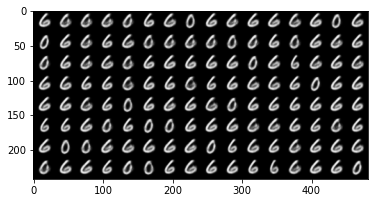

In [16]:
# Reconstruct images from random samples of the latent space 
model.to(device)
sample = torch.randn(128, nz).to(device)
sample = model.decode(sample).cpu()
sample = sample.view(-1, 1, 28, 28)
sample.shape
grid_img = make_grid(sample, nrow=16)
plt.imshow(grid_img.permute(1,2,0))


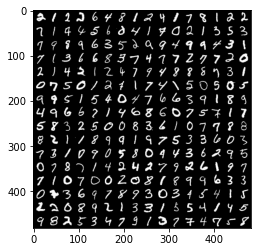

In [17]:
# compare original images and their reconstructions
originals, _ = iter(train_loader).next()
#originals.shape
grid_img = make_grid(originals, nrow=16)
plt.imshow(grid_img.permute(1,2,0))
# original:


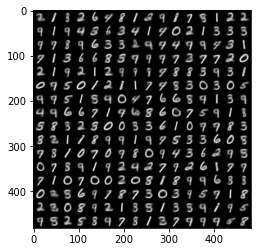

In [18]:
# and reconstruct:
model.to("cpu")
recons, _, __ = model(originals)
recons = recons.view(-1,1,28,28)
grid_img = make_grid(recons, nrow=16)
plt.imshow(grid_img.permute(1,2,0))



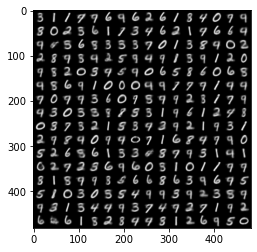

In [19]:
model.to("cpu")
xs, labels = iter(test_loader).next()
recons , mu, logvar = model(xs)
recons = recons.view(-1,1,28,28)
grid_img = make_grid(recons, nrow=16)
plt.imshow(grid_img.permute(1,2,0))


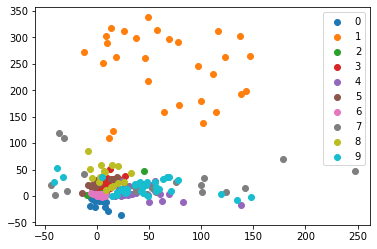

In [20]:
zs = model.reparameterize(mu, logvar)
# scatter plot of the encoding of the samples in the latent space, color coded
# each digit a different color
# not that the sample is taken from the testing data set, meaning the model hasn't been trained on it
z = zs.detach().numpy()
z.shape
x = z[:,0]
y = z[:,1]
fig, ax = plt.subplots()
for i in range(10):
    ax.scatter(x[labels == i], y[labels == i], label=str(i))
#ax.scatter(x,y, c=labels, label=labels)
ax.legend()
